# Set up

In [ ]:
import pandas as pd
import datetime
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import math
import pymc as pm
import kaleido
import matplotlib.pyplot as plt

In [ ]:
def upload_and_clean(file_path: str, year: int):
  df = pd.read_csv(file_path)

  df['Registration Date'] = pd.to_datetime(
      df['Registration Date'],
      errors='coerce',
      dayfirst=True
  )

  df = df.dropna(subset=['Registration Date'])

  df['Registration Date'] = df['Registration Date'].apply(
      lambda dt: dt.replace(year=year) if dt.year % 100 != year % 100 else dt
  )

  df['Student Name'] = df['Student First Name'] + ' ' + df['Student Last Name']

  return df

In [ ]:
### CHOOSE DATA SET ###

enroll1 = upload_and_clean('/content/Enrollment data for Sophie G(Q3 2025).csv', 2025)
enroll2 = upload_and_clean('/content/Enrollment data for Sophie G(Q3 2024).csv', 2025)
enroll = pd.concat([enroll1,enroll2],ignore_index=True)

/tmp/ipython-input-2820301425.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-2820301425.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



next time: figure out how i want to be combining data sets -- Q3 with Q3, Q2 with Q2

In [ ]:
print(enroll.head())

   Order ID Registration Date Registration Time    General category  \
0     37981        2025-07-21           2:49 PM  1:1 Essay Coaching   
1     37570        2025-07-06          12:34 AM            SAT Prep   
2     38265        2025-08-01           8:48 PM            SAT Prep   
3     38636        2025-08-28           3:18 PM            SAT Prep   
4     38782        2025-09-14           3:22 PM            SAT Prep   

                        Product/Class  Gross amount  Discounted amount  \
0  1:1 College Essay Writing Coaching         400.0              400.0   
1          SAT Prep at Crofton HS 714         199.0              199.0   
2        SAT Prep at Annapolis HS 809         219.0              199.0   
3      SAT Prep at South River HS 927         219.0              199.0   
4    SAT Prep at North County HS 1004         199.0              199.0   

  Student First Name  Student Last Name                 Student Email  ...  \
0             Kinsey              Smith     kinsey

In [ ]:
### INITIALIZE VARIABLES ###

MIN_SIZE = 3 # will not run class with fewer than 3 students
MAX_DAYS_BUCKET = 15

# Filtering

In [ ]:
# Last 3-4 digits of every class name is the date it took place (eg. 730 is July 30).
# We filter out classes without digits at the end because we need class dates.

def is_valid_class(df: pd.DataFrame) -> pd.Series:
  return (
    df['Product/Class'].str.contains('SAT PREP|ACT PREP|WORKSHOP|COURSE',case=False) &
    df['Product/Class'].str[-3:].str.isdigit()
  )

In [ ]:
def extract_class_date(class_name: str, year: int):
  """
  Extract day and month from end of class name.
  Given year, month, day in form "730" or "1129", gives "7-30-2025".
  """
  day = class_name[-2:]
  month = class_name[-4:-2]
  monthday = date(year,int(month),int(day))
  return monthday

In [ ]:
classes = enroll[is_valid_class(enroll)].copy()

In [ ]:
# Registration year assumed to be class year
def date_difference(df: pd.DataFrame):
  df['Year'] = df['Registration Date'].map(lambda x: x.year)

  df['Class date'] = df.apply(
    lambda row: extract_class_date(row['Product/Class'], row['Year']),
    axis = 1 # 1 is to apply to each row instead of each column
  )

  # Calculating time difference in days
  df['Class date'] = pd.to_datetime(df['Class date'])
  df['Registration Date'] = pd.to_datetime(df['Registration Date'])

  df['Days before class'] = (
    df['Class date'] - df['Registration Date']
  ).dt.days

  return df

In [ ]:
classes = date_difference(classes)

Still have to design function to decide what the year should be; need to ensure that class date is AFTER reg date.

In [ ]:
# filtering out negative values
valid_classes = classes[~(classes['Days before class'] < 0)].copy()

# Creating days before class count

In [ ]:
def build_days_before(df: pd.DataFrame) -> dict:
    result = {}

    for class_name in df['Product/Class'].unique():
        result[class_name] = (
            df[df['Product/Class'] == class_name]
            .groupby('Days before class')
            .agg(Students = ('Student Name', 'count'))
            .reset_index()
        )

    return result

In [ ]:
days_before_class = build_days_before(valid_classes)

In [ ]:
# print(days_before_class['SAT Prep at Johns Hopkins University 927'])

# Bucketing days into 15+

In [ ]:
def bucket_days(df: pd.DataFrame, days_bucket: int) -> pd.DataFrame:
  df = df.copy()

  df['Days before class'] = (
     df['Days before class']
     .clip(lower=0, upper=days_bucket)
  )

  return df

In [ ]:
for class_name in days_before_class:
  days_before_class[class_name] = bucket_days(days_before_class[class_name],
                                                               MAX_DAYS_BUCKET)

In [ ]:
# print(days_before_class['SAT Prep at Johns Hopkins University 927'])

# Cumulative student counts

In [ ]:
# Creating cumulative count of students registered x days before class date

def build_cumulative_counts(df: pd.DataFrame, index_range: range, index_col: str) -> pd.DataFrame:
    df = (
      df.groupby(index_col)['Students'].sum()
      .reindex(index_range, fill_value=0)[::-1]
      .cumsum()
      .reset_index()
      .set_index(index_col)
    )

    return df

In [ ]:
cum_days_before = {
    c: build_cumulative_counts(days_before_class[c], range(0, MAX_DAYS_BUCKET + 1), 'Days before class')
    for c in days_before_class
}

In [ ]:
# print(cum_days_before['SAT Prep at Johns Hopkins University 927'])

# Combining classes into one df

In [ ]:
# Transposing so that weeks/days before are columns and rows are unique classes

def combine_classes(dfs: dict, index_range: range) -> pd.DataFrame:
   result = {
      i: [dfs[class_name].at[i, 'Students'] for class_name in dfs]
      for i in index_range
   }

   return pd.DataFrame(result)

In [ ]:
summary = combine_classes(cum_days_before, range(0, MAX_DAYS_BUCKET+1))
summary['Success'] = [0 if summary[0].iloc[i] < 3 else 1 for i in range(len(summary))]
# success is 1, failure is 0
summary['Class name'] = cum_days_before.keys()

In [ ]:
print(summary.head())

   0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  Success  \
0  4  4  3  3  3  3  3  3  2  1   1   1   0   0   0   0        1   
1  7  7  7  7  7  6  6  6  6  5   5   4   4   3   3   3        1   
2  8  8  8  8  8  8  8  8  8  8   8   8   8   8   8   8        1   
3  3  3  3  3  3  3  2  2  2  1   1   1   1   1   1   1        1   
4  3  3  3  3  3  2  2  2  2  2   2   2   2   2   2   2        1   

                             Class name  
0            SAT Prep at Crofton HS 714  
1          SAT Prep at Annapolis HS 809  
2        SAT Prep at South River HS 927  
3      SAT Prep at North County HS 1004  
4  SAT Prep at Archbishop Curley HS 920  


# Frequentist/percentile approach

In [ ]:
### FREQUENTIST APPROACH FOR EACH CLASS/DAY COMBINATION ###

def find_percentile(data: pd.Series, level: int) -> int:
  """
  Percentile is rounded down; [1,2,3,4,5] will give 2 for 45%.
  """
  sorted = data.sort_values().reset_index(drop=True)
  size = len(sorted) + 1

  percentile = max(math.floor(level / 100 * size),1)

  return sorted[percentile-1]

In [ ]:
def build_percentiles(df: pd.DataFrame, level: int) -> pd.DataFrame:
  percentiles = []
  for day in range(0,MAX_DAYS_BUCKET+1):
    percentiles.append(find_percentile(df[day],level))

  perc_df = pd.DataFrame(percentiles, columns=[f'{level}th percentile class'])
  perc_df.index.name = 'Days before class'

  return perc_df

In [ ]:
percentile5th = build_percentiles(summary,5)

In [ ]:
print(build_percentiles(summary,25))
# graph of percent of classes that had at least three by certain day before

                   25th percentile class
Days before class                       
0                                      2
1                                      2
2                                      2
3                                      2
4                                      1
5                                      1
6                                      1
7                                      1
8                                      1
9                                      1
10                                     1
11                                     1
12                                     1
13                                     1
14                                     0
15                                     0


In [ ]:
def percent_successful(df: pd.DataFrame, student_count: int) -> pd.DataFrame:
  percents = []

  for i in range(1,MAX_DAYS_BUCKET+1): # day 0 is final class count
    successes = len(df[(df[0] >= MIN_SIZE) & (df[i] == student_count)])
    total = len(df[df[i] == student_count])
    if total == 0:
      percent_success = 0
    else:
      percent_success = round(successes / total, 2)
    percents.append(percent_success)

  return percents

In [ ]:
percent_success_zero_students = percent_successful(summary, student_count = 0)
percent_success_one_student = percent_successful(summary, student_count = 1)
percent_success_two_students = percent_successful(summary, student_count = 2)

In [ ]:
print(percent_success_zero_students) # just not enough data -- 1/2 is 50% even though only two classes have 0 at that time
print(percent_success_one_student)
print(percent_success_two_students)
# how do i make sure this is meaningful without getting more data?
# not enough classes with size = 0
# use beta prior to inform p(s|x=0)

[0, 0.0, 0.5, 0.4, 0.33, 0.22, 0.25, 0.29, 0.31, 0.29, 0.29, 0.4, 0.42, 0.39, 0.39]
[0.0, 0.09, 0.05, 0.04, 0.04, 0.15, 0.16, 0.19, 0.34, 0.36, 0.36, 0.32, 0.34, 0.4, 0.41]
[0.19, 0.19, 0.26, 0.37, 0.47, 0.57, 0.64, 0.75, 0.7, 0.75, 0.76, 0.82, 0.8, 0.8, 0.85]


In [ ]:
def build_percent_above_min(df: pd.DataFrame) -> pd.DataFrame:
  """
  Percent of classes that are at class min by i days before class.
  """
  num_classes = len(df)
  percents = []
  ones = [1] * num_classes

  for day in range(0,MAX_DAYS_BUCKET+1):
    p = len(df[df[day] > MIN_SIZE - 1][day]) / num_classes
    percents.append(p)

  early_cancel_risk = [ones[i]-percents[i] for i in range(len(percents))]

  perc_df = pd.DataFrame({'Percent above minimum' : percents,
                          'Risk of erroneous cancellation' : early_cancel_risk})
  perc_df.index.name = 'Days before class'

  return perc_df

In [ ]:
print(build_percent_above_min(summary))

                   Percent above minimum  Risk of erroneous cancellation
Days before class                                                       
0                                   0.62                            0.38
1                                   0.58                            0.42
2                                   0.56                            0.44
3                                   0.54                            0.46
4                                   0.52                            0.48
5                                   0.50                            0.50
6                                   0.44                            0.56
7                                   0.41                            0.59
8                                   0.35                            0.65
9                                   0.32                            0.68
10                                  0.30                            0.70
11                                  0.29           

# Binning days to improve data sparsity

In [ ]:
bins = ['1-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14', '15+']

summary_binned = pd.DataFrame(
    {
        bins[i]: summary[[(2*i+1),(2*i+2)]].max(axis=1)
        for i in range(len(bins)-1)
    }
)
summary_binned['15+'] = summary[15]
summary_binned = summary_binned

In [ ]:
print(summary_binned.head())

   1-2  3-4  5-6  7-8  9-10  11-12  13-14  15+
0    4    3    3    3     1      1      0    0
1    7    7    6    6     5      4      3    3
2    8    8    8    8     8      8      8    8
3    3    3    3    2     1      1      1    1
4    3    3    2    2     2      2      2    2


In [ ]:
students_binned = summary_binned.mask(summary_binned <= 1, '0-1').map(lambda x: str(x))
summary_binned_str = summary_binned.map(lambda x: str(x))

In [ ]:
print(students_binned.head())

  1-2 3-4 5-6 7-8 9-10 11-12 13-14  15+
0   4   3   3   3  0-1   0-1   0-1  0-1
1   7   7   6   6    5     4     3    3
2   8   8   8   8    8     8     8    8
3   3   3   3   2  0-1   0-1   0-1  0-1
4   3   3   2   2    2     2     2    2


In [ ]:
for df in [summary_binned_str, students_binned, summary_binned]:
  df['Final count'] = summary[0]
  df['Success'] = summary['Success']
  df['Class name'] = summary['Class name']

In [ ]:
print(summary_binned.head())

   1-2  3-4  5-6  7-8  9-10  11-12  13-14  15+  Final count  Success  \
0    4    3    3    3     1      1      0    0            4        1   
1    7    7    6    6     5      4      3    3            7        1   
2    8    8    8    8     8      8      8    8            8        1   
3    3    3    3    2     1      1      1    1            3        1   
4    3    3    2    2     2      2      2    2            3        1   

                             Class name  
0            SAT Prep at Crofton HS 714  
1          SAT Prep at Annapolis HS 809  
2        SAT Prep at South River HS 927  
3      SAT Prep at North County HS 1004  
4  SAT Prep at Archbishop Curley HS 920  


In [ ]:
print(students_binned.head())

  1-2 3-4 5-6 7-8 9-10 11-12 13-14  15+  Final count  Success  \
0   4   3   3   3  0-1   0-1   0-1  0-1            4        1   
1   7   7   6   6    5     4     3    3            7        1   
2   8   8   8   8    8     8     8    8            8        1   
3   3   3   3   2  0-1   0-1   0-1  0-1            3        1   
4   3   3   2   2    2     2     2    2            3        1   

                             Class name  
0            SAT Prep at Crofton HS 714  
1          SAT Prep at Annapolis HS 809  
2        SAT Prep at South River HS 927  
3      SAT Prep at North County HS 1004  
4  SAT Prep at Archbishop Curley HS 920  


In [ ]:
print(summary_binned.iloc[:,7].head()) # this is a series

0    0
1    3
2    8
3    1
4    2
Name: 15+, dtype: int64


# Bayesian inference/Beta prior

In [ ]:
# initializing prior constants (alpha/beta)
prior_strength = 2 # weak; eg., Beta(1,1) (uniform distribution) has prior strength 2
overall_success = summary['Success'].mean()
alpha = overall_success * prior_strength
beta = (1-overall_success) * prior_strength

In [ ]:
def beta_success(df: pd.DataFrame, student_count: int) -> list:
  probabilities = []

  for i in range(0, len(bins)):
    successes = len(df[(df['Success'] == 1) & (df.iloc[:,i] == student_count)])
    failures = len(df[(df['Success'] == 0) & (df.iloc[:,i] == student_count)])
    post_alpha = alpha + successes
    post_beta = beta + failures

    # chance of success is ~Bin(n,p) where p~Beta(alpha+successes,beta+failures)
    # E[p] = (alpha + successes) / (alpha + beta + successes + failures)
    p_mean = round(post_alpha / (post_alpha + post_beta) * 100, 2)

    # ensure probabilities are monotonically decreasing
    if len(probabilities)>0 and p_mean < probabilities[-1]:
      probabilities.append(probabilities[-1])
    else:
      probabilities.append(p_mean)

  return probabilities

In [ ]:
# probability of success for a class with X students N days before class
# where X is 0-1 or 2 and N is 1-2, 3-4, etc.
def build_prob_success(df: pd.DataFrame, student_counts: list):
  prob_success = pd.DataFrame({
      f'{student_count} students' : beta_success(df,student_count)
      for student_count in student_counts
  })

  add_zeros = pd.DataFrame([[0]*len(prob_success.columns)],columns=prob_success.columns)
  combined = pd.concat([add_zeros,prob_success],ignore_index=True)

  combined['Days before class'] = ['0'] + bins

  return combined

In [ ]:
binned_prob_success = build_prob_success(students_binned,['0-1','2'])
unbinned_prob_success = build_prob_success(summary_binned_str,['0','1','2'])

In [ ]:
print(binned_prob_success)
# still issues with probabilities increasing as days decrease

   0-1 students  2 students Days before class
0          0.00        0.00                 0
1          5.39       22.78               1-2
2         12.96       28.96               3-4
3         12.96       48.76               5-6
4         21.13       63.50               7-8
5         34.48       69.27              9-10
6         35.08       74.96             11-12
7         38.34       77.88             13-14
8         40.71       81.60               15+


# Logistic model

Idea is that you model the probability with logistic regression so that it doesn't show increases in success when students decrease -- assuming the constant beta_1 is what we expect, logistic model forces monotone decreasing probabilities.

First, we have to convert to long format so that we can use day bins as a variable.

In [ ]:
summary_long = summary_binned.melt(
    id_vars = ['Final count','Success','Class name'],
    value_vars = bins,
    var_name = 'Days before',
    value_name = 'Students'
)

In [ ]:
print(summary_long.head())

   Final count  Success                            Class name Days before  \
0            4        1            SAT Prep at Crofton HS 714         1-2   
1            7        1          SAT Prep at Annapolis HS 809         1-2   
2            8        1        SAT Prep at South River HS 927         1-2   
3            3        1      SAT Prep at North County HS 1004         1-2   
4            3        1  SAT Prep at Archbishop Curley HS 920         1-2   

   Students  
0         4  
1         7  
2         8  
3         3  
4         3  


In [ ]:
"""
day_codes, day_idx = np.unique(summary_long['Days before'], return_inverse=True)

students = summary_long['Students'].values
success = summary_long['Success'].values

with pm.Model() as model:

  # hyperpriors
  beta_0 = pm.Normal('beta_0', mu=0, sigma=5)
  beta_1 = pm.Normal('beta_1', mu=0, sigma=2)

  sigma_u = pm.HalfNormal('sigma_u', sigma=1)

  # creating random variable for intercepts for day buckets
  u_raw = pm.Normal("u_raw", mu=0, sigma=1, shape=len(day_codes))
  u = pm.Deterministic("u", u_raw * sigma_u)

  # model
  logit_p = beta_0 + u[day_idx] + beta_1 * students

  # likelihood
  p = pm.math.sigmoid(logit_p)
  y = pm.Bernoulli('y', p=p, observed=success)

  trace = pm.sample(
      target_accept=0.95,
      draws=2000,
      tune=2000
      )
"""

'\nday_codes, day_idx = np.unique(summary_long[\'Days before\'], return_inverse=True)\n\nstudents = summary_long[\'Students\'].values\nsuccess = summary_long[\'Success\'].values\n\nwith pm.Model() as model:\n\n  # hyperpriors\n  beta_0 = pm.Normal(\'beta_0\', mu=0, sigma=5)\n  beta_1 = pm.Normal(\'beta_1\', mu=0, sigma=2)\n  \n  sigma_u = pm.HalfNormal(\'sigma_u\', sigma=1)\n\n  # creating random variable for intercepts for day buckets\n  u_raw = pm.Normal("u_raw", mu=0, sigma=1, shape=len(day_codes))\n  u = pm.Deterministic("u", u_raw * sigma_u)\n\n  # model\n  logit_p = beta_0 + u[day_idx] + beta_1 * students\n\n  # likelihood\n  p = pm.math.sigmoid(logit_p)\n  y = pm.Bernoulli(\'y\', p=p, observed=success)\n\n  trace = pm.sample(\n      target_accept=0.95,\n      draws=2000,\n      tune=2000\n      )\n'

# Visualization

In [ ]:
def plot_prob_success(df: pd.DataFrame):
  fig = go.Figure()

  for i in range(len(df.columns)-1):
    fig.add_trace(
      go.Scatter(
          x=df['Days before class'],
          y=df.iloc[:,i],
          mode='lines',
          name=df.columns[i]
      )
    )

  fig.update_layout(
      xaxis=dict(
          type='category',
          categoryorder='array',
          categoryarray=df['Days before class']
      ),
      yaxis=dict(
          title='Percent chance of success',
          range=[0, 100]
      ),
      xaxis_title='Days before class'
  )

  fig.show()

In [ ]:
plot_prob_success(binned_prob_success)

In [ ]:
def plot_for_slides(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(8, 4.5))

    x = df["Days before class"]

    for col in df.columns:
        if col == "Days before class":
            continue
        ax.plot(x, df[col], linewidth=2, label=col)

    # Labels and limits
    ax.set_xlabel("Days before class")
    ax.set_ylabel("Percent chance of success")
    ax.set_ylim(0, 100)

    # Remove default padding so 0 aligns with the origin
    ax.margins(x=0, y=0)

    # Ensure x is treated as categorical but starts at 0
    ax.set_xlim(-0.0, len(x) - 1)

    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x)

    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("success_probability.png", dpi=300, bbox_inches="tight")
    plt.close()

In [ ]:
plot_for_slides(binned_prob_success)

# Exploratory data analysis/misc.

In [ ]:
### EXPLORATORY DATA ANALYSIS ###

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_student_count(df: pd.DataFrame, x_max=20, y_max=10):
    count = df.groupby('Product/Class')['Student Name'].count()

    bins = np.arange(1, x_max + 2, 1)  # 1 to x_max inclusive

    plt.figure()
    plt.hist(count, bins=bins)

    plt.xlim(1, 15)
    plt.ylim(0, 30)
    plt.xticks(np.arange(1, 15 + 1, 1))
    plt.yticks(np.arange(0, 30 + 1, 1))

    plt.xlabel("Students per class")
    plt.ylabel("Number of classes")
    plt.title("Distribution of Student Counts")

    plt.tight_layout()
    plt.savefig('student_counts.png', dpi=300, bbox_inches="tight")

    plt.show()

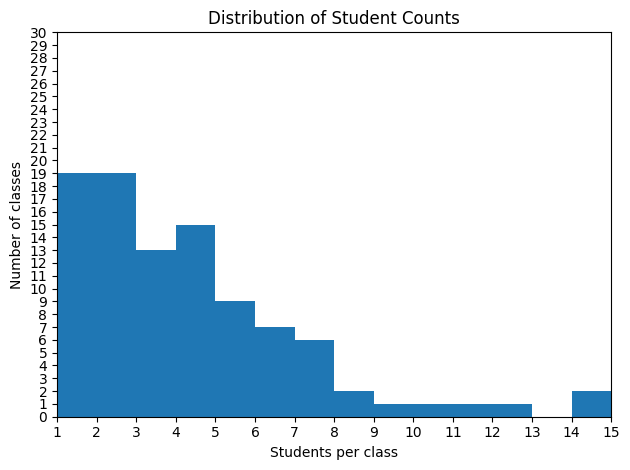

In [ ]:
plot_student_count(valid_classes)

In [ ]:
stats_days = summary.describe().T

*   median curve
*   average curve weighted by class size (since some classes are much larger than others)
*   show each class with average class overlaid
*   plot for each class type -- separate them
*   survival-analysis (Kaplan-Meier): probability that a student has not yet enrolled by X day (research more!)

In [ ]:
# How many classes of each type occurred in Q3?
# 1st row is # classes, 2nd row is # students taking a class of that type

def build_class_breakdown(df: pd.DataFrame) -> pd.DataFrame:
    class_count = [
        sum(df['Product/Class']
            .value_counts()
            .index
            .str.contains(i,case=False))
        for i in ['SAT PREP', 'ACT PREP', 'WORKSHOP', 'COURSE']
    ]

    student_count = [
        len(df[df['Product/Class']
                          .str.contains(i,case=False)])
        for i in ['SAT PREP', 'ACT PREP', 'WORKSHOP', 'COURSE']
    ]

    result = pd.DataFrame([class_count,student_count],
                                   columns=['SAT PREP', 'ACT PREP', 'WORKSHOP', 'COURSE'])

    return result

In [ ]:
class_breakdown = build_class_breakdown(valid_classes)

In [ ]:
print(class_breakdown) # none of the ACT prep classes have at least 3 students

   SAT PREP  ACT PREP  WORKSHOP  COURSE
0        62         6        26       6
1       335         9        88      19


In [ ]:
# When do most students sign up for a class? (aggregated as a sum across all classes)

def plot_enrollment_agg(df: pd.DataFrame):
    fig = px.histogram(df['Days before class'])

    fig.update_layout(
        xaxis = dict(title = 'Days until class'),
        yaxis = dict(title = 'Number of students'),
        title = 'Distribution of Student Enrollment Times'
    )

    fig.show()

In [ ]:
plot_enrollment_agg(valid_classes)